In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

(2115, 22, 1000)


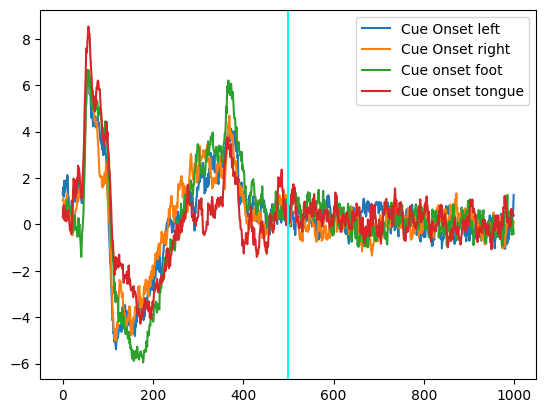

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [3]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X




In [4]:

## Preprocessing the dataset

# Filter training data by person
train_valid_indices = np.where(person_train_valid == 0)[0]
X_train_valid = X_train_valid[train_valid_indices]
y_train_valid = y_train_valid[train_valid_indices]

# Filter test data by person
test_indices = np.where(person_test == 0)[0]
X_test = X_test[test_indices]
y_test = y_test[test_indices]

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test)

## Random splitting and reshaping the data
num_samples = X_train_valid_prep.shape[0]

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(num_samples, int(0.15*num_samples), replace=False)
ind_train = np.array(list(set(range(num_samples)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (237, 22, 800)
Shape of X after maxpooling: (237, 22, 400)
Shape of X after averaging+noise and concatenating: (474, 22, 400)
Shape of X after subsampling and concatenating: (948, 22, 400)
Shape of Y: (948,)
Shape of X after trimming: (50, 22, 800)
Shape of X after maxpooling: (50, 22, 400)
Shape of training set: (806, 22, 400)
Shape of validation set: (142, 22, 400)
Shape of training labels: (806,)
Shape of validation labels: (142,)
Shape of training labels after categorical conversion: (806, 4)
Shape of validation labels after categorical conversion: (142, 4)
Shape of test labels after categorical conversion: (50, 4)
Shape of training set after adding width info: (806, 22, 400, 1)
Shape of validation set after adding width info: (142, 22, 400, 1)
Shape of test set after adding width info: (50, 22, 400, 1)
Shape of training set after dimension reshaping: (806, 400, 1, 22)
Shape of validation set after dimension reshaping: (142, 400, 1, 22)
Shape of test set 

In [5]:
# Initialize the Sequential model with the new name
rnn_model = Sequential()

# Correct the input shape by removing the extra dimension
# New input shape should be (400, 22), adjusting from (400, 1, 22)
rnn_model.add(Reshape((400, 22), input_shape=(400, 1, 22)))

# Now, your LSTM layers
rnn_model.add(LSTM(64, return_sequences=True, dropout=0.4, recurrent_dropout=0.1))
rnn_model.add(Dropout(0.6))
rnn_model.add(LSTM(32, return_sequences=True, dropout=0.4, recurrent_dropout=0.1))
rnn_model.add(Dropout(0.6))
rnn_model.add(LSTM(16, return_sequences=False, dropout=0.4, recurrent_dropout=0.1))
rnn_model.add(Dropout(0.6))

# Fully Connected Layer
rnn_model.add(Dense(40, activation='elu'))  # Adjusted for demonstration

# Output layer with Softmax activation for classification
rnn_model.add(Dense(4, activation='softmax'))

# Print the model summary to confirm the change
rnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 400, 22)           0         
                                                                 
 lstm (LSTM)                 (None, 400, 64)           22272     
                                                                 
 dropout (Dropout)           (None, 400, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 400, 32)           12416     
                                                                 
 dropout_1 (Dropout)         (None, 400, 32)           0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0

In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 100
rnn_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [7]:
# Compiling the model


rnn_model.compile(loss='categorical_crossentropy',
                 optimizer=rnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
rnn_model_results = rnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)




Epoch 1/100
13/13 [==============================] - 13s 734ms/step - loss: 1.3986 - accuracy: 0.2333 - val_loss: 1.3818 - val_accuracy: 0.2746
Epoch 2/100
13/13 [==============================] - 9s 730ms/step - loss: 1.3840 - accuracy: 0.2680 - val_loss: 1.3832 - val_accuracy: 0.2465
Epoch 3/100


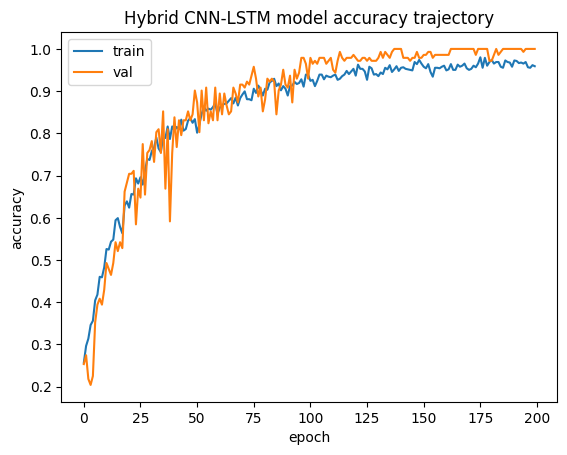

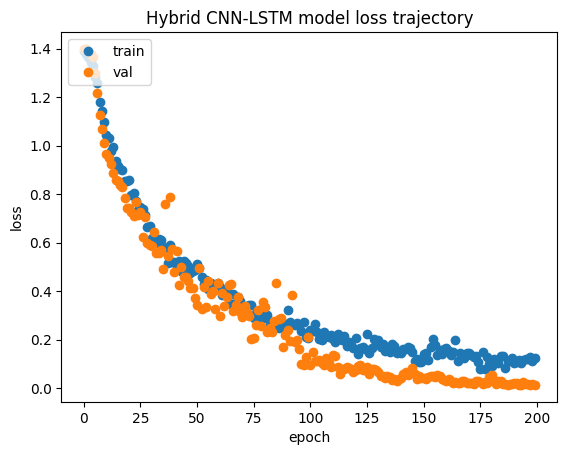

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(rnn_model_results.history['accuracy'])
plt.plot(rnn_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(rnn_model_results.history['loss'],'o')
plt.plot(rnn_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the hybrid CNN-LSTM model

rnn_score = rnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',rnn_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.6000000238418579
